In [2]:
import keras
keras.__version__

'2.1.4'

In [3]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 3us/step


In [4]:
train_data.shape

(404, 13)

In [5]:
test_data.shape

(102, 13)

In [6]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [7]:
mean = train_data.mean(axis = 0)
std = train_data.std(axis=0)

train_data -= mean
test_data -= mean

train_data /= std
test_data /= std

In [15]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### Validating your approach using K-Fold validation

In [16]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [17]:
all_scores

[2.0956787838794217, 2.220593797098292, 2.859968412040484, 2.40535704039111]

In [18]:
np.mean(all_scores)

2.3953995083523267

In [20]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [21]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [22]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

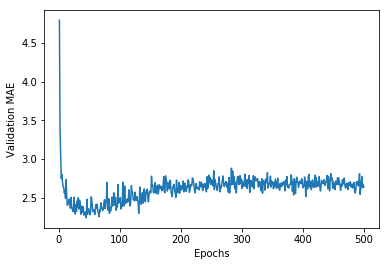

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

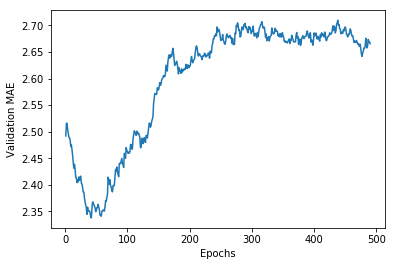

In [24]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [25]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 503us/step


In [26]:
test_mae_score

2.6750266037735284